In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from dataclasses import dataclass

DATA_DIR = '../data'
BETA_VALUES = np.sort(
    [float(x.split('fermi_')[-1]) for x in os.listdir(DATA_DIR) if x.startswith('fermi')])
n_points = len(BETA_VALUES)


@dataclass
class Data:
    data_matrix: np.array
    energy_matrix: np.array
    dst: np.array
    time: np.array


def load_data(beta):
    data_path = os.path.join(DATA_DIR, f'fermi_{beta}')
    data_matrix = np.load(os.path.join(data_path, 'dataMatrix.npy'))
    energy_matrix = np.load(os.path.join(data_path, 'energyMatrix.npy'))
    dst = np.load(os.path.join(data_path, 'dst.npy'))
    time = np.load(os.path.join(data_path, 'time.npy'))
    return Data(data_matrix=data_matrix, energy_matrix=energy_matrix, dst=dst, time=time)

print(n_points)
print(BETA_VALUES)

30
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]


(800000, 64) (120000, 64) (15000, 64)


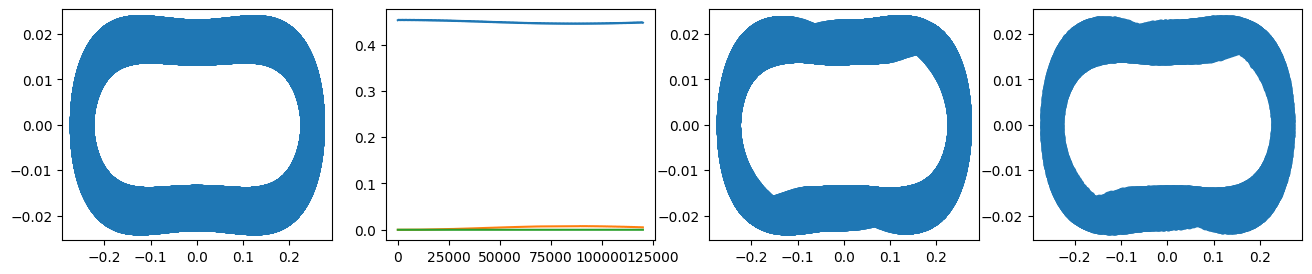

In [2]:
# load data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3))

data = load_data(0.1)
X = data.data_matrix
q, p = X[:, 0], X[:, 32]

n_portion = 120000

ax1.scatter(q, p)

ax2.plot(data.energy_matrix[:,0][:n_portion], linewidth=1.5, label="Mode 1") 
ax2.plot(data.energy_matrix[:,2][:n_portion], linewidth=1.5, label="Mode 1")
ax2.plot(data.energy_matrix[:,4][:n_portion], linewidth=1.5, label="Mode 1")

# take portion of data
X_portion = data.data_matrix[:n_portion]
q_portion, p_portion = X_portion[:, 0], X_portion[:, 32]

ax3.scatter(q_portion, p_portion)

# subsample data
X_subsample = X_portion[0::8]
q_subsample, p_subsample = X_subsample[:, 0], X_subsample[:, 32]

ax4.scatter(q_subsample, p_subsample)

print(X.shape, X_portion.shape, X_subsample.shape)

# Diffusion map

In [3]:
import datafold.dynfold as dfold
import datafold.pcfold as pfold

X_pcm = pfold.PCManifold(X_subsample)
X_pcm.optimize_parameters()

print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

dmap = dfold.DiffusionMaps(
    kernel=pfold.GaussianKernel(
        epsilon=X_pcm.kernel.epsilon, distance=dict(cut_off=X_pcm.cut_off)
    ),
    n_eigenpairs=61,
)
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

# plt.plot(evals)

In [53]:
evals

array([1.        , 0.99997143, 0.99997113, 0.99989335, 0.99987557,
       0.99974653, 0.99973341, 0.99955255, 0.99952305, 0.99929349,
       0.99926164, 0.99897566, 0.99894444, 0.99860461, 0.99856525,
       0.99817217, 0.9981322 , 0.99768229, 0.99764198, 0.99713444,
       0.99709521, 0.99652885, 0.99649193, 0.99586749, 0.99583025,
       0.9951479 , 0.99511287, 0.99437314, 0.994337  , 0.99354176,
       0.99350427, 0.99265355, 0.99261524, 0.99170869, 0.99167007,
       0.9907071 , 0.99066924, 0.98964962, 0.98961231, 0.98853634,
       0.98849957, 0.98736775, 0.98733097, 0.9861441 , 0.98610668,
       0.98486556, 0.98482701, 0.98353232, 0.98349228, 0.98214459,
       0.98210282, 0.9807027 , 0.9806589 , 0.97920694, 0.97916084,
       0.97765766, 0.97760904, 0.97605516, 0.97600403, 0.97439976,
       0.97434662])

In [38]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

evals_array = []
evals_sums = []
for beta in tqdm(BETA_VALUES):
    data = load_data(beta)

    X = data.data_matrix

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    X_pcm = pfold.PCManifold(X.T)
    X_pcm.optimize_parameters()

    dmap = dfold.DiffusionMaps(
        kernel=pfold.GaussianKernel(
            epsilon=X_pcm.kernel.epsilon, distance=dict(cut_off=X_pcm.cut_off)
        ),
        n_eigenpairs=61,
    )
    dmap = dmap.fit(X_pcm)
    _, evals = dmap.eigenvectors_, dmap.eigenvalues_

    evals_array.append(evals)
    
    evals_ = evals - min(evals)
    evals_ = evals_/sum(evals_)
    evals_sums.append(evals_.cumsum())
    
evals_array = np.array(evals_array)
evals_sums = np.array(evals_sums)

100%|██████████| 30/30 [02:11<00:00,  4.39s/it]


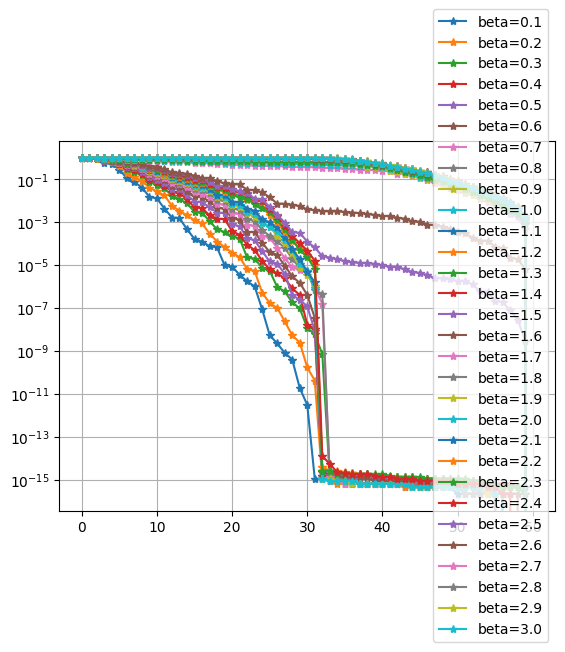

In [39]:
for i, x in enumerate(evals_array[:996]):
    scaler = MinMaxScaler()
    x_ = scaler.fit_transform(x.reshape(-1, 1))
    # x_ = x_/sum(x_)
    # csum = x_.cumsum()

    plt.plot(x_, "-*", label=f"beta={np.round(BETA_VALUES[i], 2)}")

plt.yscale('log')
plt.legend(loc='right')
# plt.xlim(-1, 20)
plt.grid()

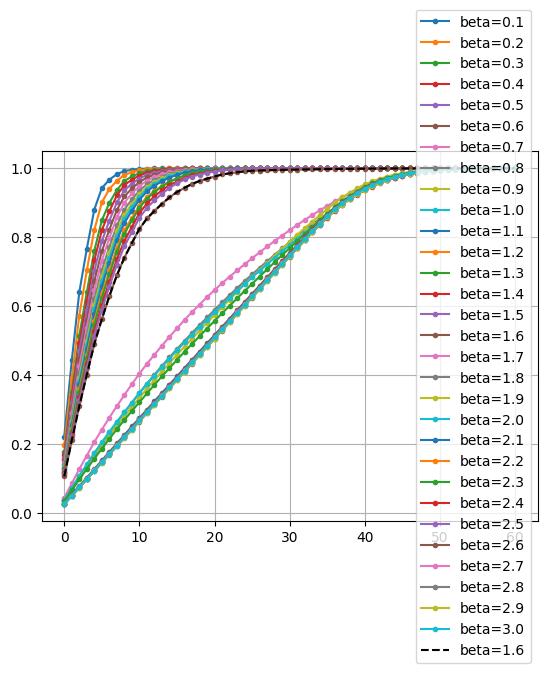

In [40]:
fig, ax = plt.subplots(1, 1)

lim = 999
for x, beta in zip(evals_sums[:lim], BETA_VALUES[:lim]):
    ax.plot(x, ".-", label=f"beta={np.round(beta, 2)}")
    
idx = 15
ax.plot(evals_sums[idx], "--", label=f"beta={np.round(BETA_VALUES[idx], 2)}", color='k')

# relabel xaxis
# ax.set_xticks(np.arange(1, 30,10))

ax.legend(loc='right')
# ax.set_xlim(0, 10)
ax.grid()
# ax.set_xlabel('PCs')
# ax.set_ylabel('cumsum expl.variance ratio')